In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_regression
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
sns.set_style("whitegrid")
sns.set_palette("pastel")
plt.rcParams['figure.figsize'] = (12, 6)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600 # Set high resolution for plots
mpl.rcParams['savefig.dpi'] = 600 # Set high resolution for saved plots

import plotly.io as pio
pio.renderers.default = 'notebook'  # Or 'notebook_connected' for JupyterLab

### 1. Data Loading & Initial Exploration

In [2]:
# Load the dataset
df = pd.read_csv('insurance.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

print("\nData types and missing values:")
display(df.info())

print("\nDescriptive statistics:")
display(df.describe(include='all'))

print("\nUnique values in categorical columns:")
print(f"Sex: {df['sex'].unique()}")
print(f"Smoker: {df['smoker'].unique()}")
print(f"Region: {df['region'].unique()}")

Dataset shape: (1338, 7)

First 5 rows:


age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


None


Descriptive statistics:


age   sex          bmi     children smoker     region  \
count   1338.000000  1338  1338.000000  1338.000000   1338       1338   
unique          NaN     2          NaN          NaN      2          4   
top             NaN  male          NaN          NaN     no  southeast   
freq            NaN   676          NaN          NaN   1064        364   
mean      39.207025   NaN    30.663397     1.094918    NaN        NaN   
std       14.049960   NaN     6.098187     1.205493    NaN        NaN   
min       18.000000   NaN    15.960000     0.000000    NaN        NaN   
25%       27.000000   NaN    26.296250     0.000000    NaN        NaN   
50%       39.000000   NaN    30.400000     1.000000    NaN        NaN   
75%       51.000000   NaN    34.693750     2.000000    NaN        NaN   
max       64.000000   NaN    53.130000     5.000000    NaN        NaN   

             charges  
count    1338.000000  
unique           NaN  
top              NaN  
freq             NaN  
mean    13270.422265  
std     12110.011237  
min      1121.873900  
25%      4740.287150  
50%      9382.033000  
75%     16639.912515  
max     63770.428010


Unique values in categorical columns:
Sex: ['female' 'male']
Smoker: ['yes' 'no']
Region: ['southwest' 'southeast' 'northwest' 'northeast']


### 2. Data Cleaning & Preprocessing


In [3]:
# Make a copy of the original data
df_clean = df.copy()

# Check for missing values
print("Missing values before cleaning:")
print(df_clean.isnull().sum())

# Convert categorical columns to proper type
cat_cols = ['sex', 'smoker', 'region']
for col in cat_cols:
    df_clean[col] = df_clean[col].astype('category')

# Check for outliers in numerical columns
num_cols = ['age', 'bmi', 'children', 'charges']

plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=df_clean[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# Handle outliers in charges (target variable)
Q1 = df_clean['charges'].quantile(0.25)
Q3 = df_clean['charges'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower bound for charges: {lower_bound}")
print(f"Upper bound for charges: {upper_bound}")

# We won't remove outliers in charges as they might represent genuine cases
# But we'll apply log transformation to reduce skewness
df_clean['log_charges'] = np.log1p(df_clean['charges'])

# Create age groups for better analysis
df_clean['age_group'] = pd.cut(df_clean['age'], 
                               bins=[0, 18, 30, 45, 60, 100],
                               labels=['0-18', '19-30', '31-45', '46-60', '60+'])

# Create BMI categories
df_clean['bmi_category'] = pd.cut(df_clean['bmi'],
                                 bins=[0, 18.5, 25, 30, 100],
                                 labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

Missing values before cleaning:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


Lower bound for charges: -13109.1508975
Upper bound for charges: 34489.350562499996


### 3. Exploratory Data Analysis (EDA)


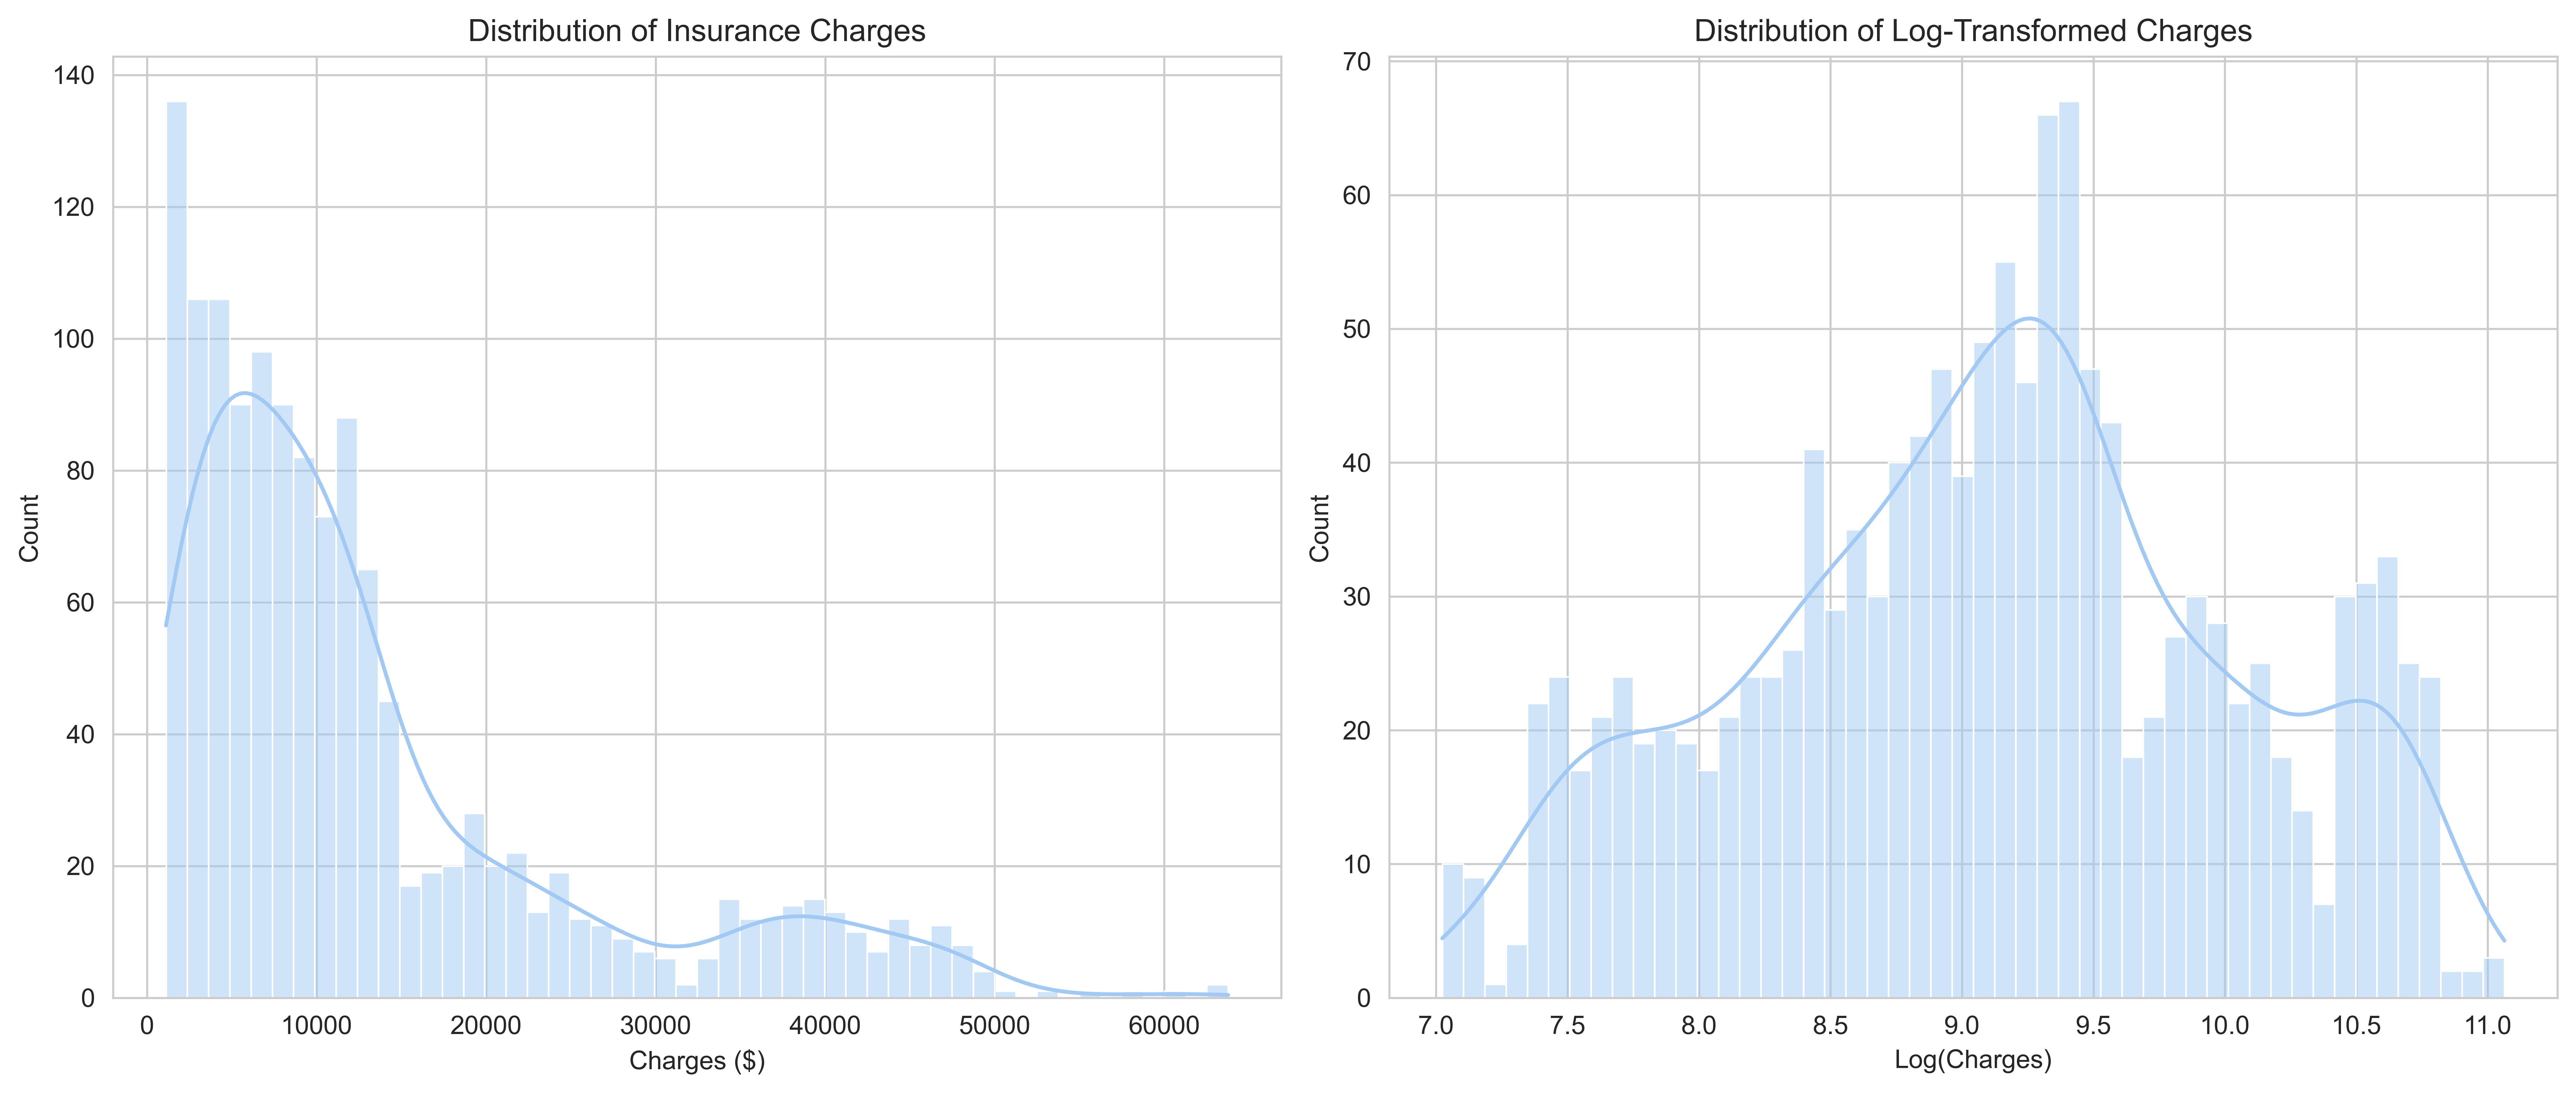

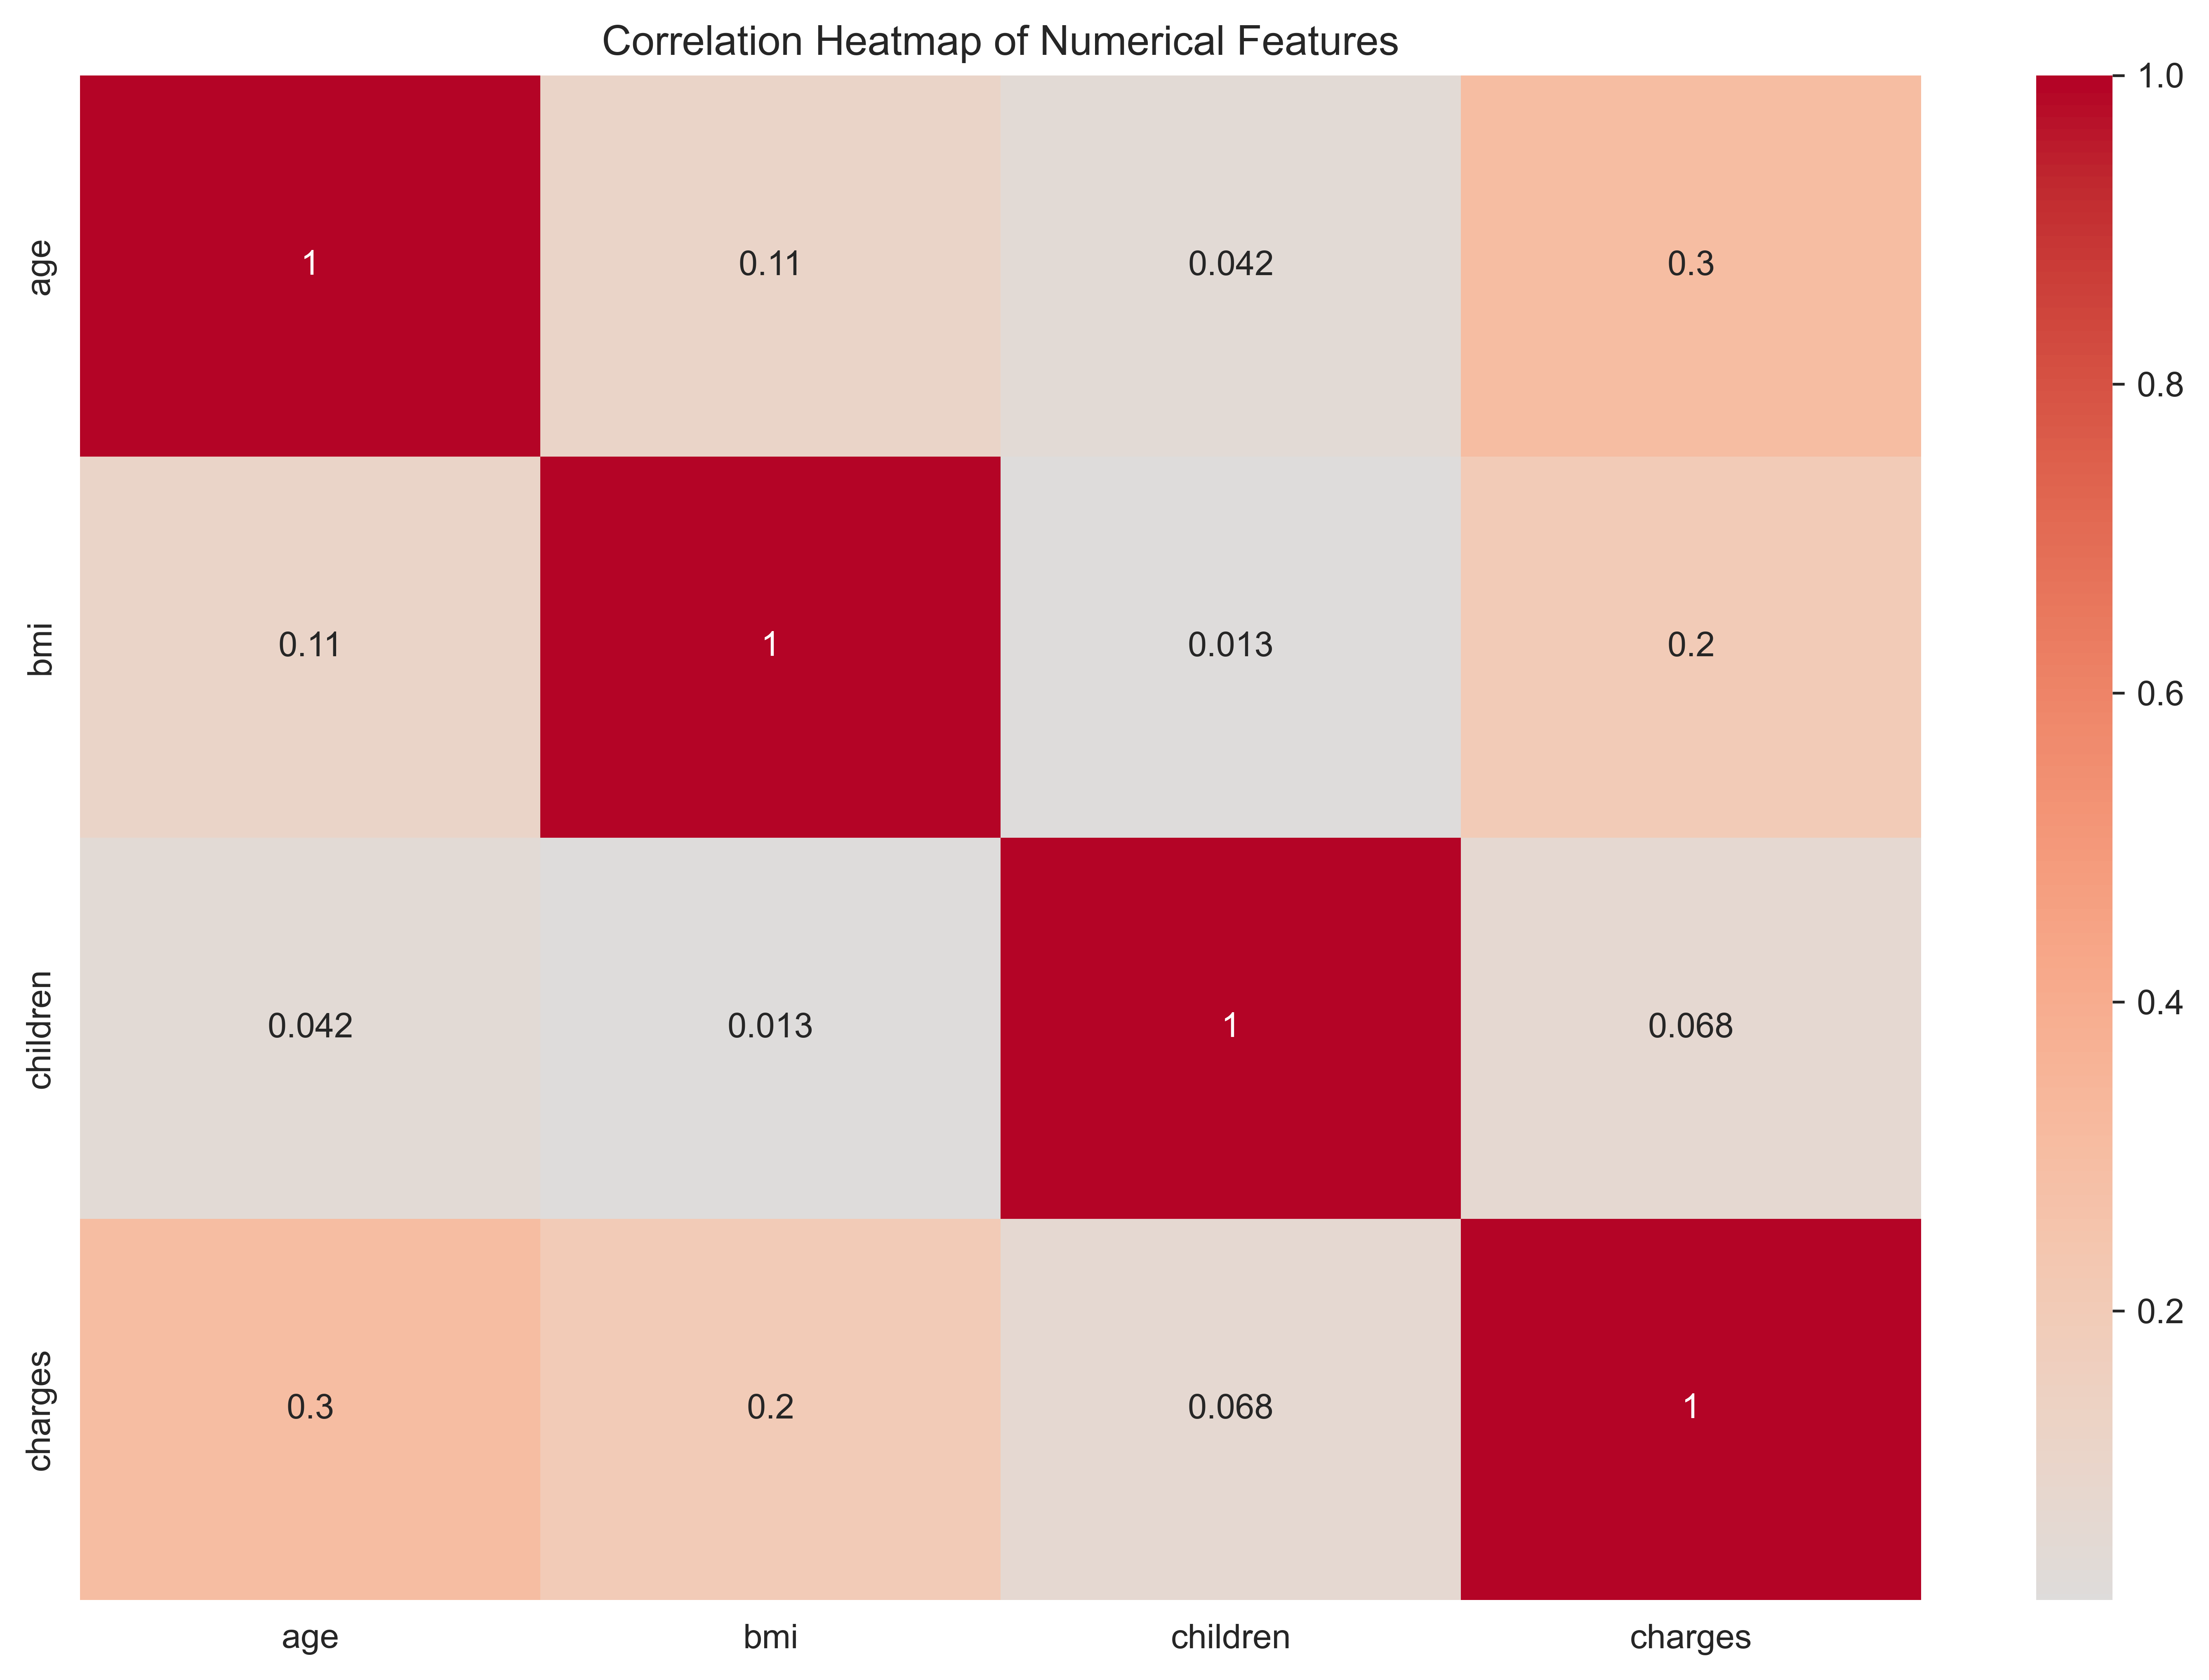

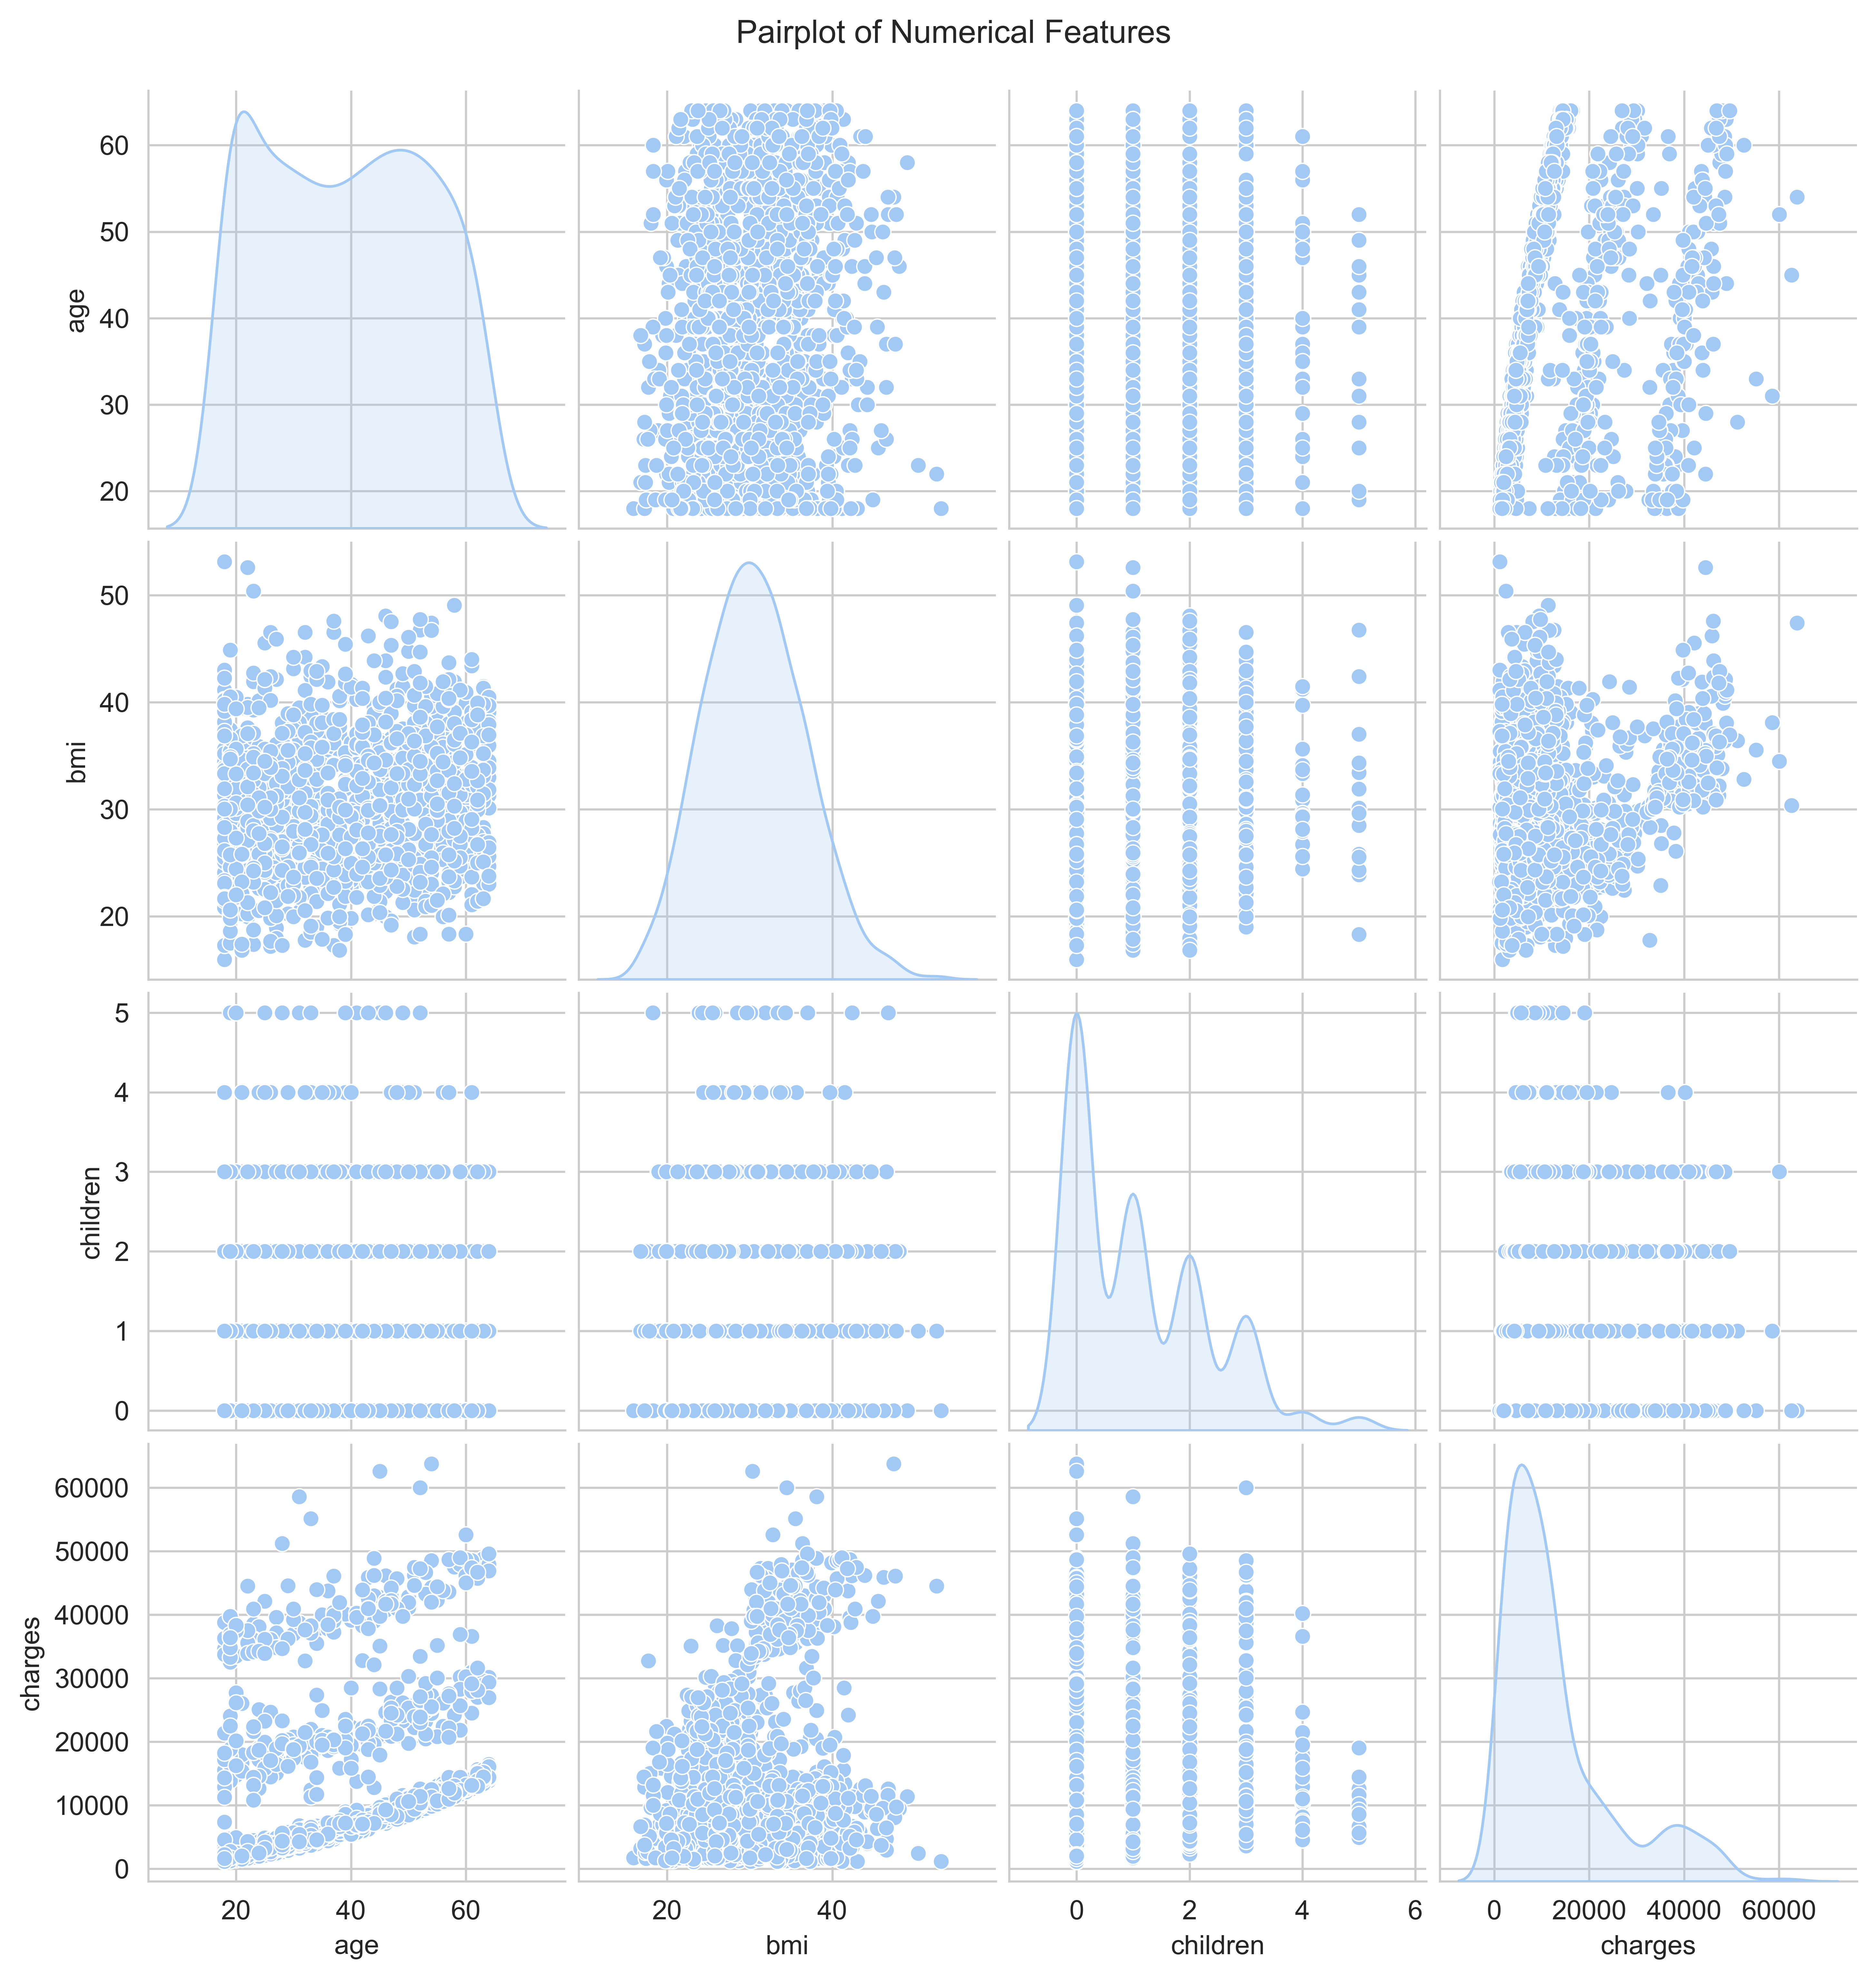

In [4]:
# Distribution of Charges (Original and Log Transformed)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_clean['charges'], bins=50, kde=True)
plt.title('Distribution of Insurance Charges')
plt.xlabel('Charges ($)')

plt.subplot(1, 2, 2)
sns.histplot(df_clean['log_charges'], bins=50, kde=True)
plt.title('Distribution of Log-Transformed Charges')
plt.xlabel('Log(Charges)')
plt.tight_layout()
plt.show()

# Charges by Categorical Features
cat_features = ['sex', 'smoker', 'region', 'age_group', 'bmi_category']
plt.figure(figsize=(18, 12))
for i, feature in enumerate(cat_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=feature, y='charges', data=df_clean)
    plt.title(f'Charges by {feature}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_clean[num_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# Pairplot of Numerical Features
sns.pairplot(df_clean[num_cols], diag_kind='kde')
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.show()

### 4. Statistical Analysis

In [5]:
# Hypothesis Testing: Do smokers have significantly higher charges?
print("\nT-test for Charges Difference Between Smokers and Non-Smokers:")
smoker_charges = df_clean[df_clean['smoker'] == 'yes']['charges']
non_smoker_charges = df_clean[df_clean['smoker'] == 'no']['charges']
t_stat, p_value = stats.ttest_ind(smoker_charges, non_smoker_charges, equal_var=False)
print(f"T-statistic: {t_stat:.2f}, p-value: {p_value:.4f}")

if p_value < 0.05:
    mean_diff = smoker_charges.mean() - non_smoker_charges.mean()
    print(f"Conclusion: Smokers have significantly {'higher' if mean_diff > 0 else 'lower'} charges (${mean_diff:,.2f} difference).")
else:
    print("Conclusion: No significant difference in charges between smokers and non-smokers.")

# ANOVA Test for Charges Across BMI Categories
print("\nANOVA Test for Charges Across BMI Categories:")
bmi_groups = df_clean['bmi_category'].unique()
charges_by_bmi = [df_clean[df_clean['bmi_category'] == bmi]['charges'] for bmi in bmi_groups]
f_stat, p_value = stats.f_oneway(*charges_by_bmi)
print(f"F-statistic: {f_stat:.2f}, p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Conclusion: There are significant differences in charges across BMI categories.")
else:
    print("Conclusion: No significant differences in charges across BMI categories.")

# Correlation between age and charges
pearson_corr, pearson_p = stats.pearsonr(df_clean['age'], df_clean['charges'])
print(f"\nPearson Correlation between Age and Charges: {pearson_corr:.2f} (p-value: {pearson_p:.4f})")

# Chi-square Test for Smoking and Sex
contingency_table = pd.crosstab(df_clean['sex'], df_clean['smoker'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"\nChi-square Test for Smoking and Sex:")
print(f"Chi2-statistic: {chi2:.2f}, p-value: {p:.4f}")

if p < 0.05:
    print("Conclusion: There is a significant association between sex and smoking status.")
else:
    print("Conclusion: No significant association between sex and smoking status.")


T-test for Charges Difference Between Smokers and Non-Smokers:
T-statistic: 32.75, p-value: 0.0000
Conclusion: Smokers have significantly higher charges ($23,615.96 difference).

ANOVA Test for Charges Across BMI Categories:
F-statistic: 18.80, p-value: 0.0000
Conclusion: There are significant differences in charges across BMI categories.

Pearson Correlation between Age and Charges: 0.30 (p-value: 0.0000)

Chi-square Test for Smoking and Sex:
Chi2-statistic: 7.39, p-value: 0.0065
Conclusion: There is a significant association between sex and smoking status.


### 5. Feature Engineering & Preprocessing for Machine Learning

In [6]:
# Prepare data for modeling
# Target variable: charges (we'll use both original and log-transformed for comparison)
# Features: All other relevant columns

# Select features and target
features = ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
target = 'charges'
log_target = 'log_charges'

# Separate features and targets
X = df_clean[features]
y = df_clean[target]
y_log = df_clean[log_target]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
_, _, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Preprocessing pipeline
numeric_features = ['age', 'bmi', 'children']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['sex', 'smoker', 'region']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Feature selection
selector = SelectKBest(score_func=f_regression, k='all')

### 6. Machine Learning Model Training & Evaluation

Linear Regression:
  Original - RMSE: 5,796.28, MAE: 4,181.19, R2: 0.78
  Log Trans - RMSE: 7,814.06, MAE: 3,888.44, R2: 0.61

Ridge Regression:
  Original - RMSE: 5,798.30, MAE: 4,186.91, R2: 0.78
  Log Trans - RMSE: 7,780.62, MAE: 3,881.88, R2: 0.61

Lasso Regression:
  Original - RMSE: 5,797.05, MAE: 4,182.08, R2: 0.78
  Log Trans - RMSE: 13,053.72, MAE: 8,603.16, R2: -0.10

Random Forest:
  Original - RMSE: 4,582.97, MAE: 2,541.61, R2: 0.86
  Log Trans - RMSE: 4,399.95, MAE: 2,080.65, R2: 0.88

Gradient Boosting:
  Original - RMSE: 4,328.15, MAE: 2,404.90, R2: 0.88
  Log Trans - RMSE: 4,447.94, MAE: 2,057.15, R2: 0.87

Support Vector Regression:
  Original - RMSE: 12,892.02, MAE: 8,605.85, R2: -0.07
  Log Trans - RMSE: 5,140.66, MAE: 2,302.17, R2: 0.83


Model Performance Comparison:


RMSE          MAE        R2
Linear Regression         Original Target   5796.284659  4181.194474  0.783593
                          Log Target        7814.064026  3888.443159  0.606698
Ridge Regression          Original Target   5798.298795  4186.913072  0.783443
                          Log Target        7780.621059  3881.879523  0.610058
Lasso Regression          Original Target   5797.054261  4182.081076  0.783536
                          Log Target       13053.719350  8603.157345 -0.097591
Random Forest             Original Target   4582.972573  2541.614594  0.864710
                          Log Target        4399.946564  2080.646795  0.875300
Gradient Boosting         Original Target   4328.147789  2404.901760  0.879336
                          Log Target        4447.935092  2057.149873  0.872565
Support Vector Regression Original Target  12892.023995  8605.845654 -0.070568
                          Log Target        5140.656196  2302.168857  0.829781

<Figure size 8400x3600 with 0 Axes>

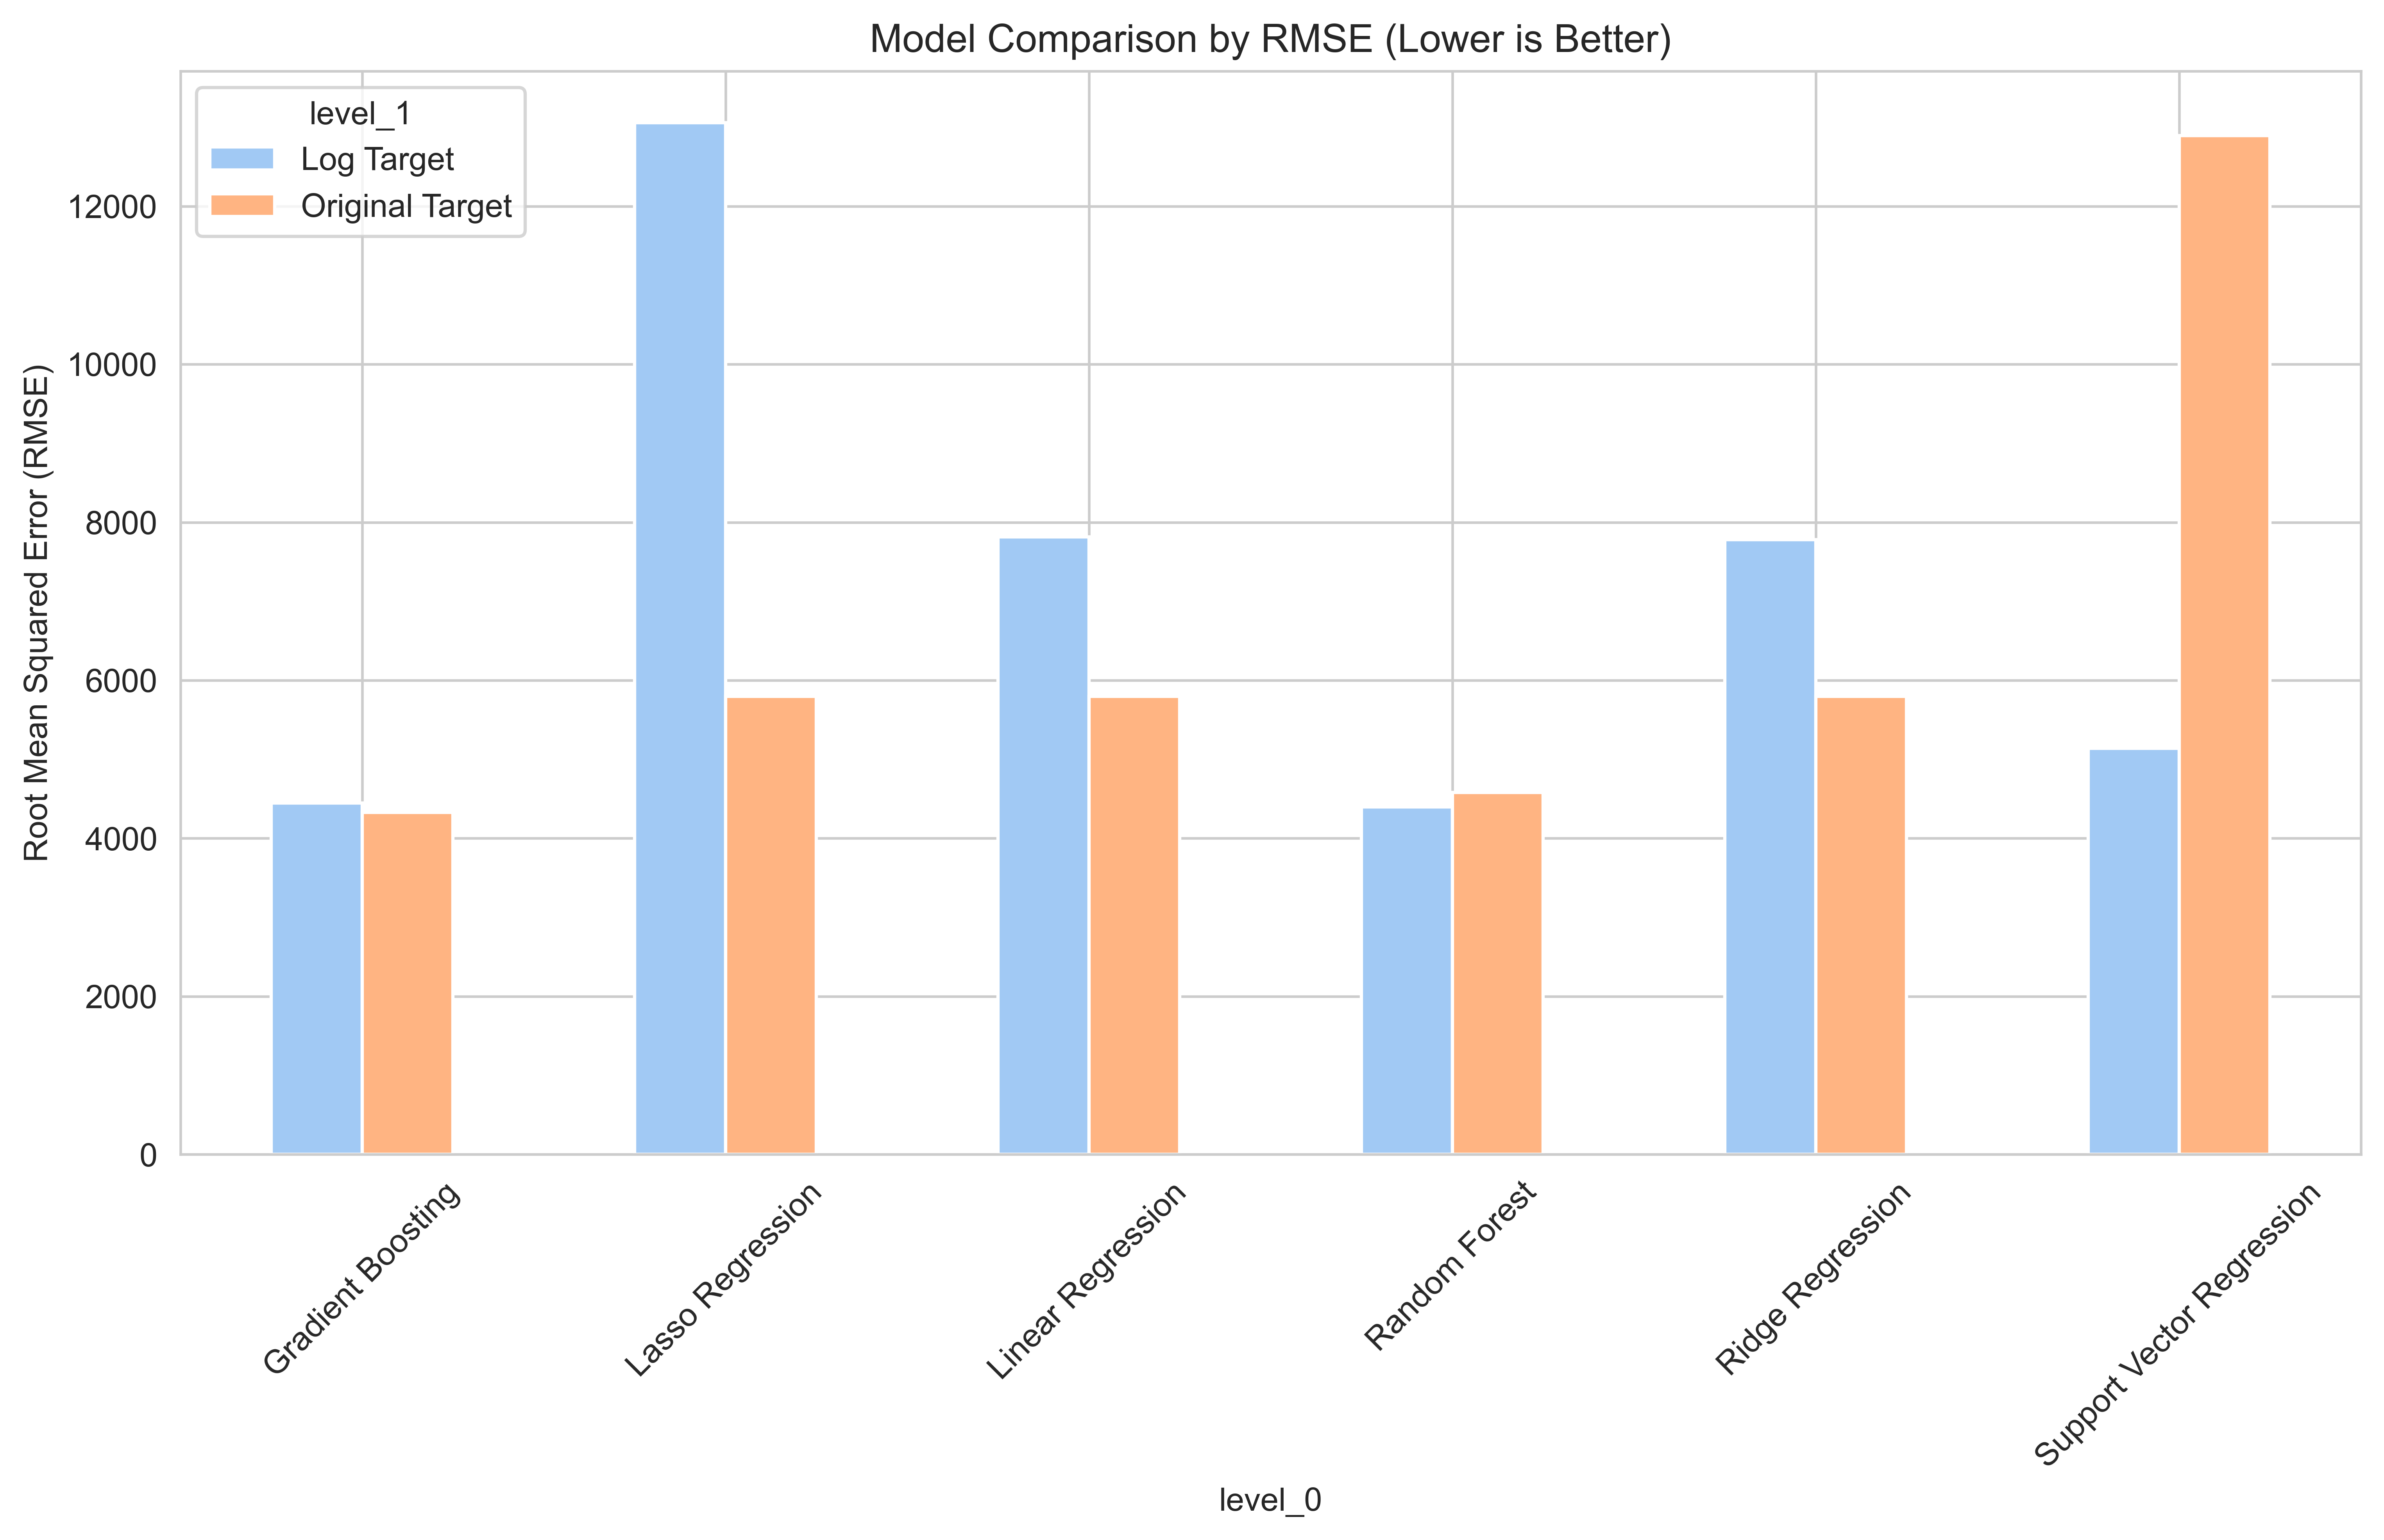

In [7]:
# Define models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regression': SVR()
}

# Evaluate each model on both original and log-transformed targets
results = {}
for name, model in models.items():
    # Create pipeline for original target
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('selector', selector),
        ('model', model)])
    
    # Create pipeline for log-transformed target
    pipeline_log = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('selector', selector),
        ('model', model)])
    
    # Fit and evaluate on original target
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Fit and evaluate on log-transformed target
    pipeline_log.fit(X_train, y_train_log)
    y_pred_log = pipeline_log.predict(X_test)
    # Convert predictions back from log scale
    y_pred_exp = np.expm1(y_pred_log)
    mse_log = mean_squared_error(y_test, y_pred_exp)
    rmse_log = np.sqrt(mse_log)
    mae_log = mean_absolute_error(y_test, y_pred_exp)
    r2_log = r2_score(y_test, y_pred_exp)
    
    # Store results
    results[name] = {
        'Original Target': {
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        },
        'Log Target': {
            'RMSE': rmse_log,
            'MAE': mae_log,
            'R2': r2_log
        },
        'model': pipeline,
        'model_log': pipeline_log
    }
    
    print(f"{name}:")
    print(f"  Original - RMSE: {rmse:,.2f}, MAE: {mae:,.2f}, R2: {r2:.2f}")
    print(f"  Log Trans - RMSE: {rmse_log:,.2f}, MAE: {mae_log:,.2f}, R2: {r2_log:.2f}")
    print()

# Compare model performance
results_df = pd.DataFrame.from_dict({(i,j): results[i][j] 
                                   for i in results.keys() 
                                   for j in results[i].keys() 
                                   if j in ['Original Target', 'Log Target']},
                                  orient='index')

print("\nModel Performance Comparison:")
display(results_df)

# Visualize model performance
plt.figure(figsize=(14, 6))
results_df.reset_index().pivot(index='level_0', columns='level_1', values='RMSE').plot(kind='bar')
plt.title('Model Comparison by RMSE (Lower is Better)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.xticks(rotation=45)
plt.show()

### 7. Hyperparameter Tuning for Best Model


Performing hyperparameter tuning for Gradient Boosting (Log Target)...

Best Parameters: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Tuned Model RMSE: 4,442.75
Tuned Model R2 Score: 0.87


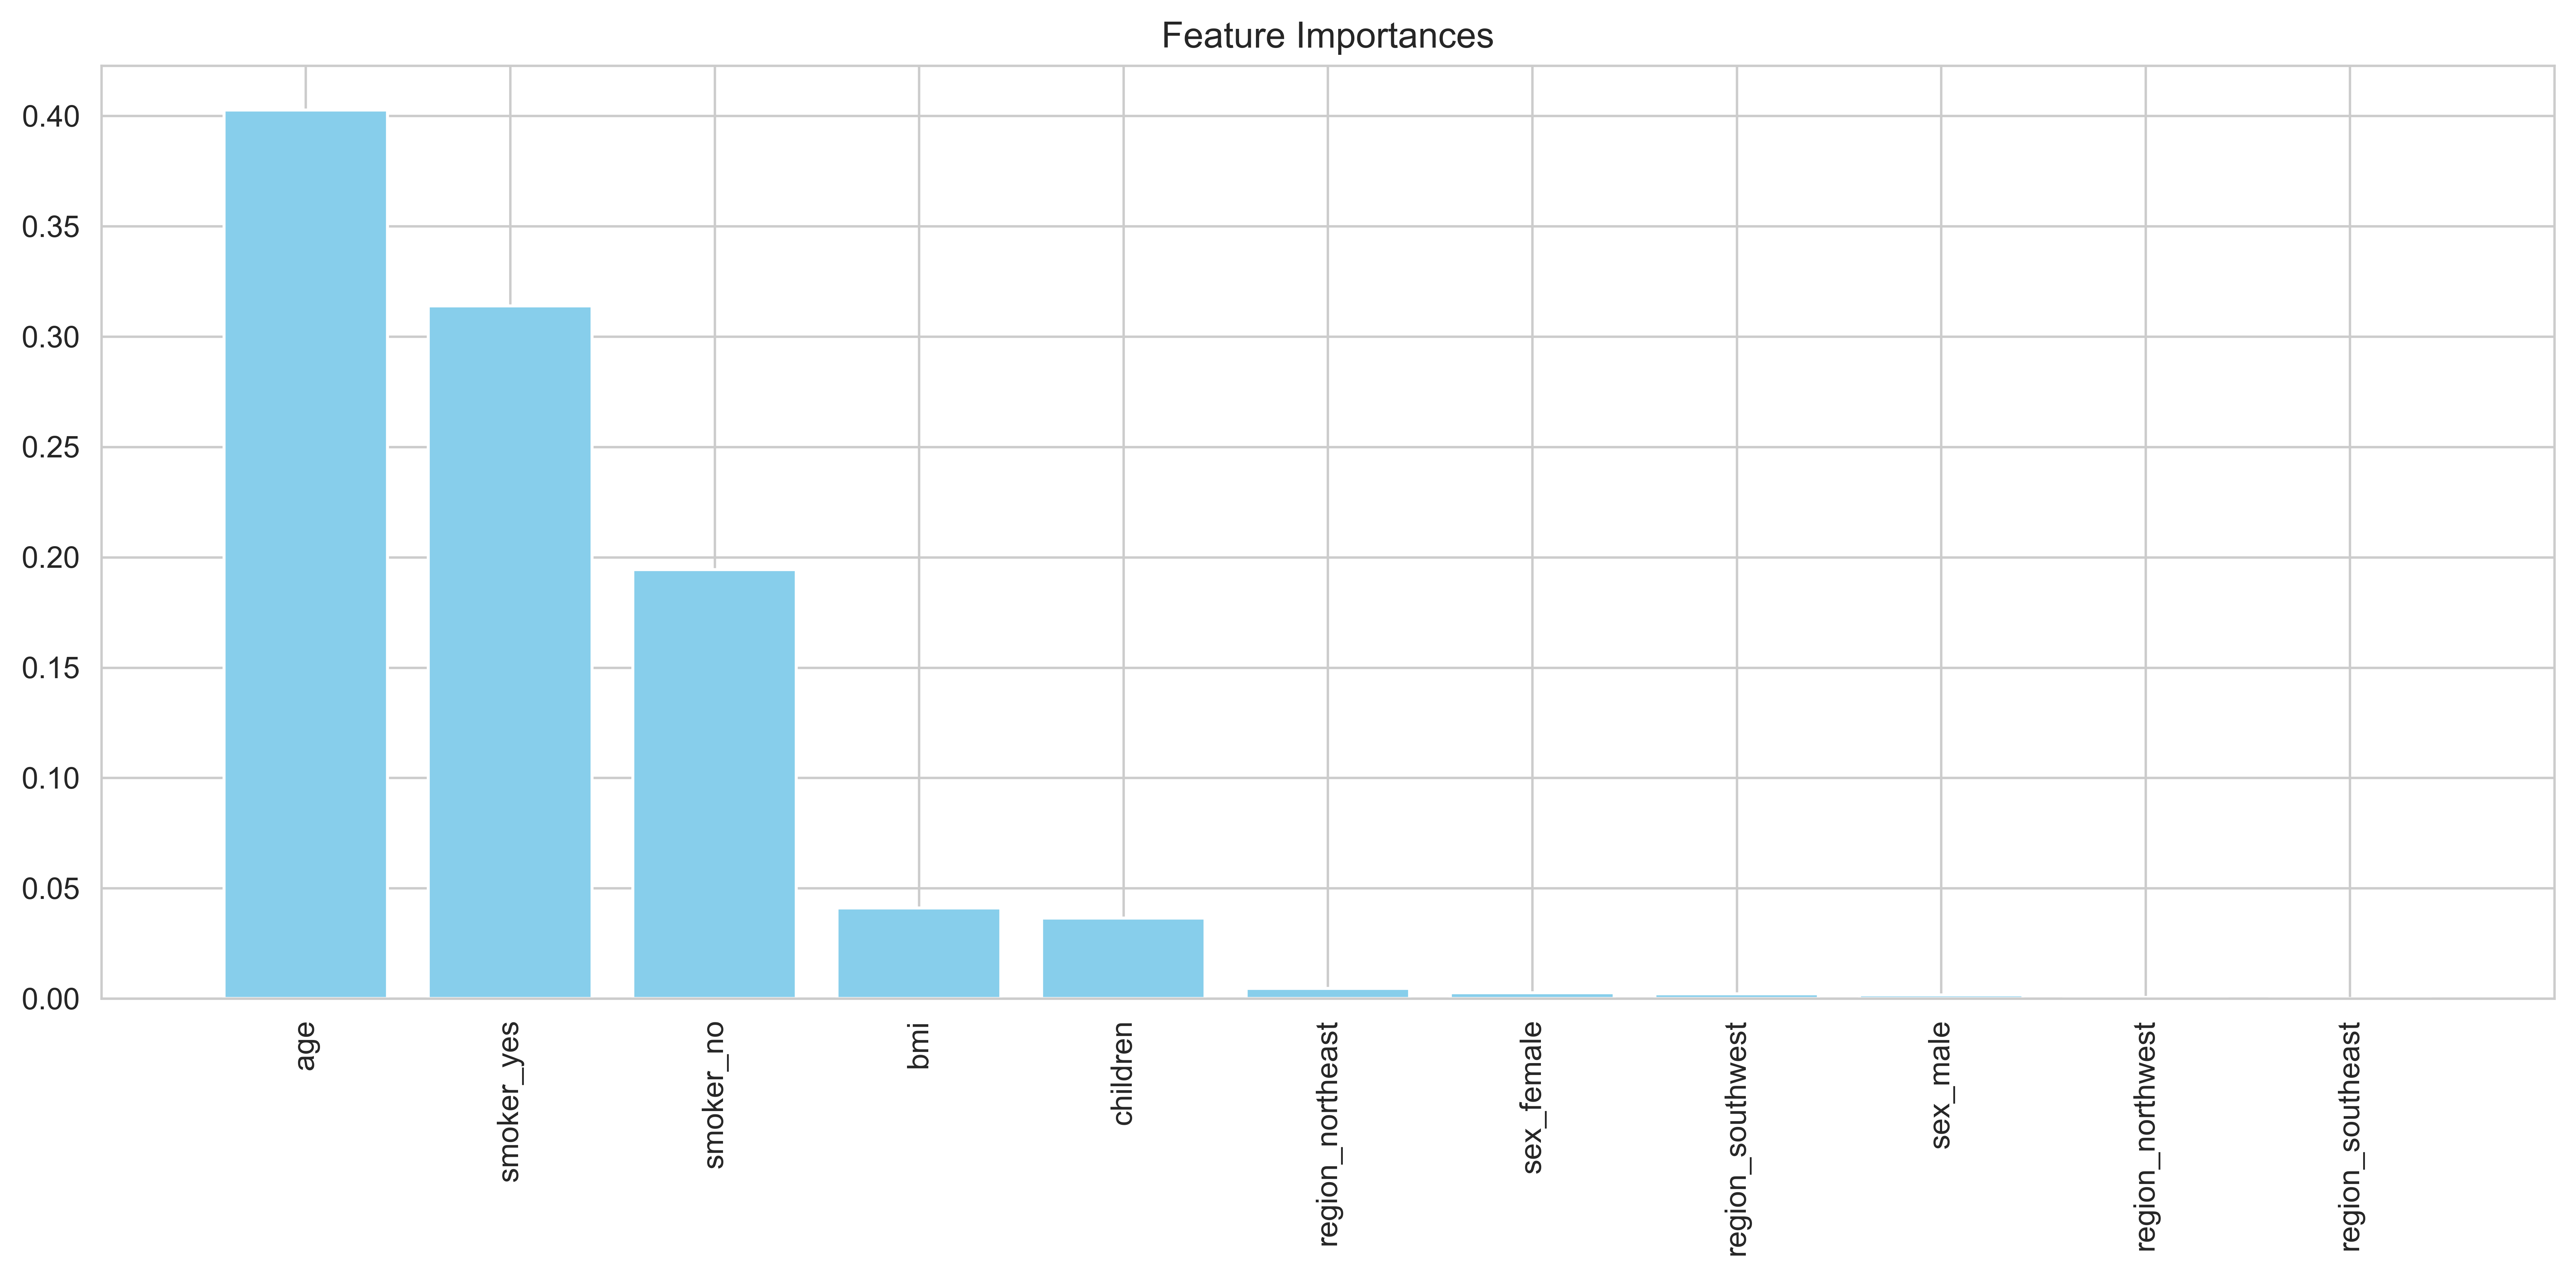

In [8]:
# Tune the best performing model (Gradient Boosting with log transform in this case)
best_model_name = 'Gradient Boosting'
best_target_type = 'Log Target'
print(f"\nPerforming hyperparameter tuning for {best_model_name} ({best_target_type})...")

# Define parameter grid for Gradient Boosting
param_grid = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [3, 5],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

# Create pipeline for GridSearchCV (using log-transformed target)
pipeline_log = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('model', GradientBoostingRegressor(random_state=42))])

# Perform GridSearchCV
grid_search = GridSearchCV(pipeline_log, param_grid, cv=5, 
                          scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train_log)

# Get best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate best model
y_pred_log = best_model.predict(X_test)
y_pred_exp = np.expm1(y_pred_log)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_exp))
r2 = r2_score(y_test, y_pred_exp)

print(f"\nBest Parameters: {best_params}")
print(f"Tuned Model RMSE: {rmse:,.2f}")
print(f"Tuned Model R2 Score: {r2:.2f}")

# Feature Importance from the best model
if hasattr(best_model.named_steps['model'], 'feature_importances_'):
    # Get feature names after preprocessing
    numeric_features_transformed = numeric_features
    categorical_features_transformed = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
    feature_names = np.concatenate([numeric_features_transformed, categorical_features_transformed])
    
    # Get feature importances
    importances = best_model.named_steps['model'].feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Plot feature importances
    plt.figure(figsize=(12, 6))
    plt.title("Feature Importances")
    plt.bar(range(len(importances)), importances[indices], color="skyblue", align="center")
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.xlim([-1, len(importances)])
    plt.tight_layout()
    plt.show()